In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv("emails.csv")

In [4]:
df.shape

(5728, 2)

In [5]:
df.groupby("spam").describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [6]:
X, y = df["text"], df["spam"]
X, y = X.to_frame(), y.to_frame()

In [7]:
X

,text
0,Subject: naturally irresistible your corporate...
1,Subject: the stock trading gunslinger fanny i...
2,Subject: unbelievable new homes made easy im ...
3,Subject: 4 color printing special request add...
4,"Subject: do not have money , get software cds ..."
...,...
5723,Subject: re : research and development charges...
5724,"Subject: re : receipts from visit jim , than..."
5725,Subject: re : enron case study update wow ! a...
5726,"Subject: re : interest david , please , call..."


In [8]:
y

,spam
0,1
1,1
2,1
3,1
4,1
...,...
5723,0
5724,0
5725,0
5726,0


In [9]:
import nltk
import re

def text_preprocess(sentence):
    # Tokenization
    tokens = nltk.word_tokenize(sentence)

    # Symbol Removal
    n_corpus = []
    for i in range(len(tokens)):
        review = re.sub(r"[^a-zA-Z]", " ", tokens[i])
        review = review.lower()
        n_corpus.append(review)

    # Stopword Removal
    stopwords = nltk.corpus.stopwords.words("english")
    rem_stopwords = [words for words in n_corpus if words not in stopwords and 
                     len(words.split()) != 0 and 
                     len(words) > 2]

    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    transformed_words = [lemmatizer.lemmatize(words) for words in rem_stopwords]

    return " ".join(transformed_words)

In [10]:
with tf.device("CPU"):
    X["new_text"] = X["text"].apply(text_preprocess)

In [11]:
X.head()

,text,new_text
0,Subject: naturally irresistible your corporate...,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,subject unbelievable new home made easy wantin...
3,Subject: 4 color printing special request add...,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",subject money get software cd software compati...


In [12]:
y["spam"]

0       1
1       1
2       1
3       1
4       1
       ..
5723    0
5724    0
5725    0
5726    0
5727    0
Name: spam, Length: 5728, dtype: int64

Visualizing spam words

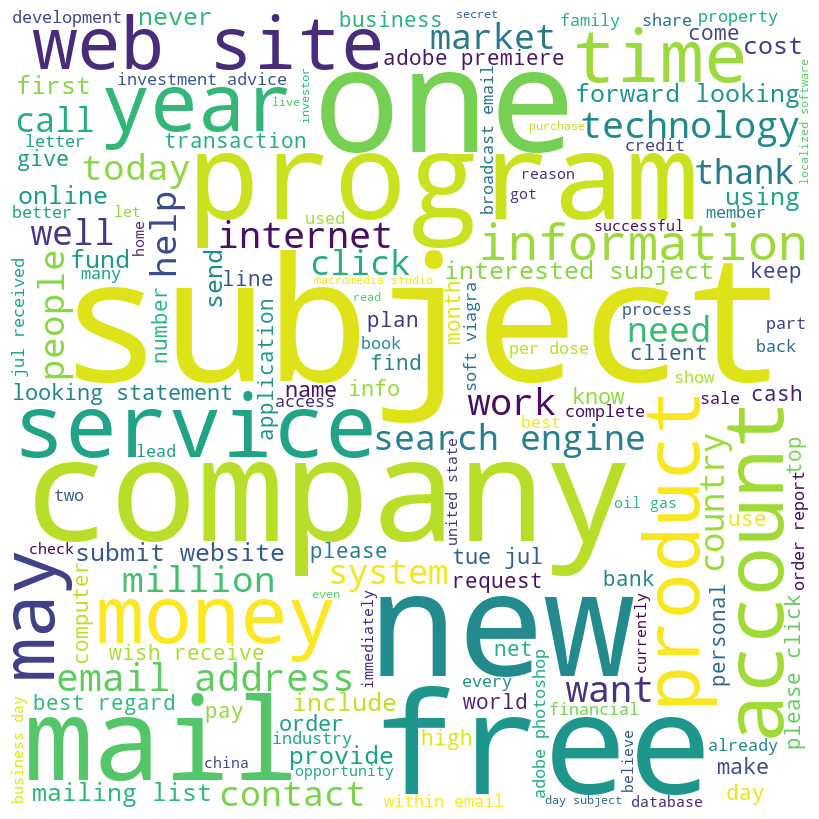

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 1])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Visualizing ham words

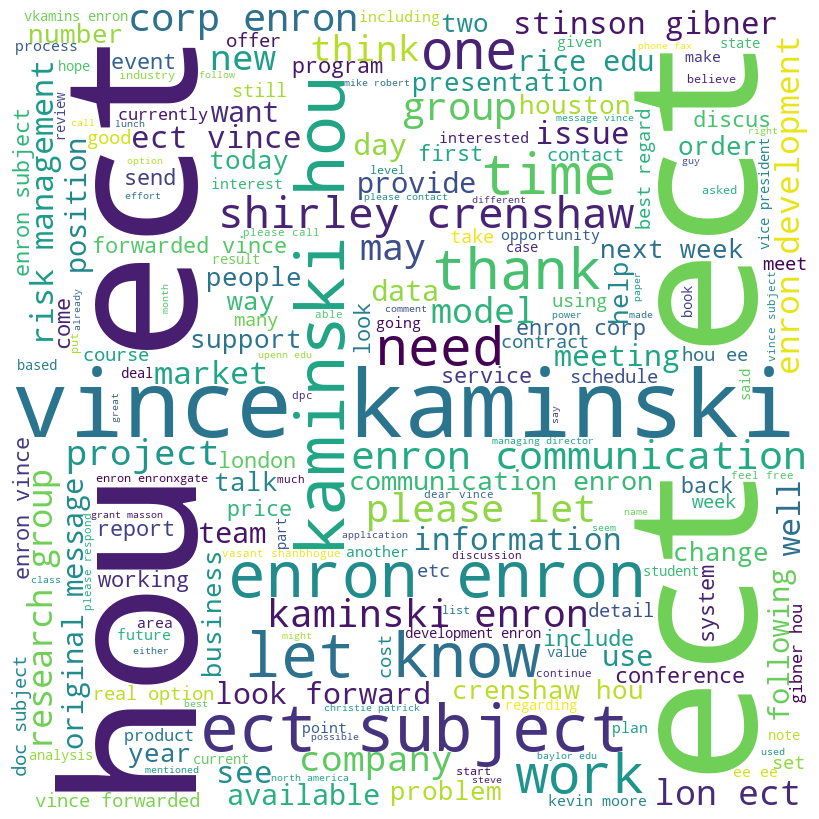

In [14]:
comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 0])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

One hot Encoding

In [15]:
from tensorflow.keras.preprocessing.text import one_hot

In [16]:
vocab_size = 5000

In [17]:
encoded_words = [one_hot(words, vocab_size) for words in X["new_text"]]

Word Embedding

In [18]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [19]:
max_length = len(max(X["new_text"]))

In [20]:
embedded_words = pad_sequences(encoded_words, padding="pre", maxlen=max_length)
print(embedded_words)

[[   0    0    0 ... 4712 4878 2219]
 [   0    0    0 ... 4257 2491 2892]
 [   0    0    0 ...  338 4042  185]
 ...
 [   0    0    0 ... 4984 3337  599]
 [   0    0    0 ...  388 4769  357]
 [   0    0    0 ... 1030 2361 1454]]


Model

In [21]:
feature_dim = 50

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(vocab_size, feature_dim ,input_length=max_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 581, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 581, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_final, y_final = np.array(embedded_words), np.array(y)

In [25]:
X_final.shape

(5728, 581)

In [26]:
y_final.shape

(5728, 1)

Splitting into Training and Testing

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42)

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10


68/68 [==============================] - 9s 73ms/step - loss: 0.3796 - accuracy: 0.8373 - val_loss: 0.1776 - val_accuracy: 0.9595
Epoch 2/10
68/68 [==============================] - 5s 79ms/step - loss: 0.1746 - accuracy: 0.9614 - val_loss: 0.1062 - val_accuracy: 0.9651
Epoch 3/10
68/68 [==============================] - 5s 70ms/step - loss: 0.0548 - accuracy: 0.9863 - val_loss: 0.0765 - val_accuracy: 0.9714
Epoch 4/10
68/68 [==============================] - 5s 69ms/step - loss: 0.0224 - accuracy: 0.9942 - val_loss: 0.0683 - val_accuracy: 0.9763
Epoch 5/10
68/68 [==============================] - 5s 68ms/step - loss: 0.0126 - accuracy: 0.9967 - val_loss: 0.0699 - val_accuracy: 0.9784
Epoch 6/10
68/68 [==============================] - 5s 67ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0502 - val_accuracy: 0.9797
Epoch 7/10
68/68 [==============================] - 5s 67ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0837 - val_accuracy: 0.9777
Epoch 8/10
68/68 [======

In [29]:
y_pred = model.predict(X_test)
y_pred

array([[2.3816832e-04],
       [4.1257619e-05],
       [1.6904429e-05],
       ...,
       [2.9572799e-05],
       [9.9994671e-01],
       [4.4263212e-05]], dtype=float32)

In [30]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1053,   10],
       [  16,  353]], dtype=int64)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9818435754189944

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1063
           1       0.97      0.96      0.96       369

    accuracy                           0.98      1432
   macro avg       0.98      0.97      0.98      1432
weighted avg       0.98      0.98      0.98      1432

